<a href="https://colab.research.google.com/github/tomassams/tdt4173-machine-learning-project/blob/main/project_notebook_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

<p align="center">

# TDT4173 Project Assignment

# A comparison of KNN and CNN for image classification

## KNN Implementation

</p>

</div>



## 1 Setup and prerequisites

In [44]:
"""

    Import necessary libraries

"""
%matplotlib inline
from matplotlib import pyplot as plt
from google.colab import files
import seaborn as sns
import pandas as pd
import numpy as np
import os
import imutils
import cv2
import pickle 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [2]:
"""

    If the notebook is running in Colab, we want to download models and results
    when they are ready so they don't get lost if Colab times out.

    This global variable keeps track of that.

"""
RunningInCOLAB = 'google.colab' in str(get_ipython())

In [3]:
"""

    Set up our project folder structure

"""
def create_folder_unless_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_folder_unless_exists('data/raw')
create_folder_unless_exists('data/zip')
create_folder_unless_exists('models')
create_folder_unless_exists('results/knn_pixel_intensity')
create_folder_unless_exists('results/knn_color_histogram')

In [4]:
"""
    Download and unzip the dataset

    1. Downloads the zip-file with wget
    2. Unzips it into the root folder
    3. Moves it into the ./data/raw/ folder
    4. Moves the original zip file to the ./data/zip/ folder

    If you are not running in a Colab environment, you might need to do this manually.

    Folder structure should look like this after:

    |-- project root
    |   |--> ...
    |   |--> ...
    |   |--> data
    |        |--> zip
    |             |--> kvasir-dataset-v2.zip
    |        |--> raw
    |             |--> dyed-lifted-polyps
    |             |--> dyed-resection-margins
    |             |--> esophagitis
    |             |--> normal-cecum
    |             |--> normal-pylorus
    |             |--> normal-z-line
    |             |--> polyps
    |             |--> ulcerative-colitis

"""
!wget "https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip"
!unzip -qq kvasir-dataset-v2.zip
!mv kvasir-dataset-v2/* data/raw
!mv kvasir-dataset-v2.zip data/zip
!rm kvasir-dataset-v2 -rf

--2020-11-13 09:36:54--  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘kvasir-dataset-v2.zip’

kvasir-dataset-v2.z 100%[===================>]   2.32G  87.1MB/s    in 26s     

2020-11-13 09:37:21 (91.3 MB/s) - ‘kvasir-dataset-v2.zip’ saved [2489312085/2489312085]



In [81]:
"""
A helper utility to generate a pretty confusion matrix
"""
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          save_path=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    plt.colorbar()
    plt.rcParams.update({'font.size': 18})


    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=18, ha="right")
        plt.yticks(tick_marks, target_names, fontsize=18)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.autoscale()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=16)

    if save_path:
        plt.savefig(save_path)

    plt.show()

## 2 Preprocessing and feature extraction

In [13]:
"""
    Collect all our image paths
"""
img_paths = list(imutils.paths.list_images('data/raw'))

# Print first 10 to see if they make sense
img_paths[:10]

['data/raw/dyed-lifted-polyps/3983e21f-6989-47d9-9188-fff27302579b.jpg',
 'data/raw/dyed-lifted-polyps/338876e1-4a56-4b7c-af24-84ab62a871fd.jpg',
 'data/raw/dyed-lifted-polyps/9bd429fa-b80a-448a-90ef-dc8a5976c2d6.jpg',
 'data/raw/dyed-lifted-polyps/d44a92f6-e974-427b-9a47-5ddc45010732.jpg',
 'data/raw/dyed-lifted-polyps/d222fafd-9bd4-4d87-ac23-42e80b4e3bc0.jpg',
 'data/raw/dyed-lifted-polyps/1ee63f40-8517-4741-b3a3-0a644c3fa0f4.jpg',
 'data/raw/dyed-lifted-polyps/b54a1b23-2c6c-48bf-bce7-7ebd2d152715.jpg',
 'data/raw/dyed-lifted-polyps/83ce36e3-32ee-4739-9107-c180d16576f7.jpg',
 'data/raw/dyed-lifted-polyps/fabe6262-ce05-48a5-b0fd-170af0d90d1a.jpg',
 'data/raw/dyed-lifted-polyps/07b354f4-412e-4fb3-95aa-75b7409ce334.jpg']

In [14]:
def image_to_feature_vector(image, size=(32, 32)):
	"""
		Feature extraction
		Resize an image and flatten it into a list of raw pixels
	"""
	return cv2.resize(image, size).flatten()

def extract_color_histogram(image, bins=(8, 8, 8)):
	"""
		Feature extraction
		Extract a 3D color histogram in HSV color space
	"""
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,[0, 180, 0, 256, 0, 256])


	if imutils.is_cv2(): # special handling if OpenCV 2.4.X
		hist = cv2.normalize(hist)
	else:
		cv2.normalize(hist, hist)

	return hist.flatten()

In [15]:
def extract_dataset_features(img_paths, histogram_bins=(8,8,8), image_size=(32,32)):
	data_raw_pixels = []
	data_color_histogram = []
	data_labels = []

	# Go through all our image paths to extract features
	for (i, img_path) in enumerate(img_paths):

		# Extract image and label from path
		image = cv2.imread(img_path)
		label = img_path.split(os.path.sep)[-2].split(".")[0]

		# Extract raw pixel intensity features
		pixels = image_to_feature_vector(image, size=image_size)

		# Extract color histogram to characterize the color distribution of the pixels
		histogram = extract_color_histogram(image, bins=histogram_bins)

		# Update the raw images, features, and labels matricies respectively
		data_raw_pixels.append(pixels)
		data_color_histogram.append(histogram)
		data_labels.append(label)

		# Print an update every 1.000 images
		if i > 0 and i % 1000 == 0:
			print(f"processed {i}/{len(img_paths)}")

	print("Done processing")
 
	return (data_raw_pixels, data_color_histogram, data_labels)

data_raw_pixels, data_color_histogram, data_labels = extract_dataset_features(img_paths)

processed 1000/8000
processed 2000/8000
processed 3000/8000
processed 4000/8000
processed 5000/8000
processed 6000/8000
processed 7000/8000
Done processing


In [19]:
# retrieve unique labels and their indices to use later
unique_labels, unique_indices = np.unique(data_labels, return_index=True)

dyed-lifted-polyps


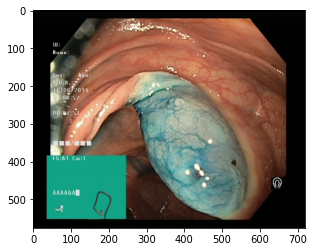

dyed-resection-margins


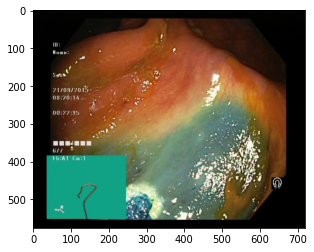

esophagitis


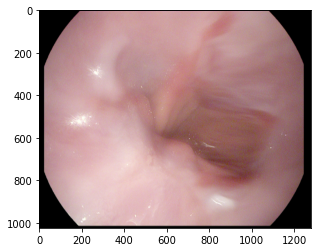

normal-cecum


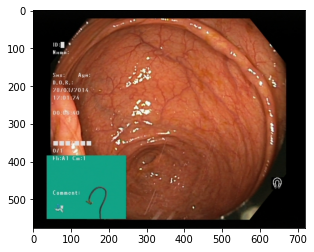

normal-pylorus


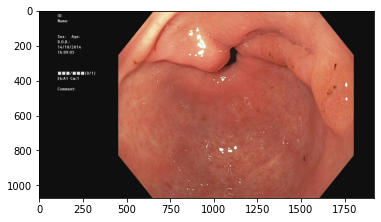

normal-z-line


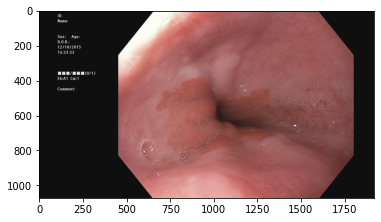

polyps


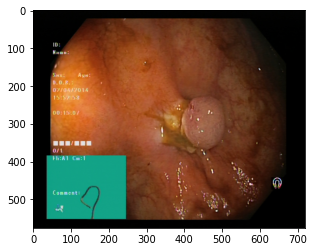

ulcerative-colitis


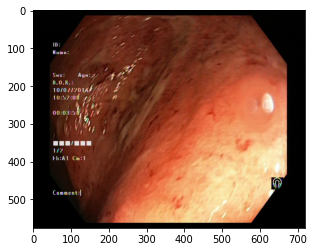

In [22]:
# show an example of each class with image + label
for (i, index) in enumerate(unique_indices):
    path = img_paths[index]
    label = data_labels[index]

    img = cv2.imread(path)
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    print("=============")
    print(label)
    plt.imshow(rgb_image)
    plt.show()
    print("=============")

In [23]:
# Transform to numpy arrays
data_raw_pixels = np.array(data_raw_pixels)
data_color_histogram = np.array(data_color_histogram)
data_labels = np.array(data_labels)

In [24]:
print("data_raw_pixels: {:.2f}MB".format(data_raw_pixels.nbytes / (1024 * 1000.0)))
print("data_color_histogram: {:.2f}MB".format(data_color_histogram.nbytes / (1024 * 1000.0)))

data_raw_pixels: 24.00MB
data_color_histogram: 16.00MB


## 3 Model training

In [27]:
"""
    We will be performing a grid search to find optimal hyperparameters, based on this search grid.
"""
grid_params = {
    'n_neighbors': [3, 5, 11, 19],
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan']
}

### 3.1 Pixel intensity model

In [25]:
"""
    Split our dataset into training (80%) and testing (20%)
"""
x_train_raw_pixels, x_test_raw_pixels, y_train_raw_pixels, y_test_raw_pixels = train_test_split(data_raw_pixels, data_labels, test_size=0.25, random_state=42, stratify=data_labels)

In [29]:
"""
    Perform a grid search to find optimal hyperparameters
"""
print("Performing grid search on pixel intensity based features")
gs_rp = GridSearchCV(estimator=KNeighborsClassifier(), cv=3, param_grid=grid_params, verbose = 1, n_jobs = -1)
gs_results_rp = gs_rp.fit(x_train_raw_pixels, y_train_raw_pixels)

Performing grid search on pixel intensity based features
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 24.3min finished


In [32]:
"""
    Our best parameter results
"""
best_params_rp = gs_rp.best_params_ 
best_model_rp = gs_rp.best_estimator_
best_score_rp = gs_rp.best_score_

# Save model
pickle.dump(best_model_rp, open('models/knn_pixel_intensity.pkl', 'wb'))

# Download if we're in Colab
if RunningInCOLAB:
    files.download('models/knn_pixel_intensity.pkl') 

print(f"Best performing raw pixels model got {best_score_rp*100:.2f}% acc with params: {best_params_rp}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Best performing raw pixels model got 63.38% acc with params: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}


In [33]:
"""
    Output the results table
"""
df_rp = pd.DataFrame(gs_rp.cv_results_).sort_values('rank_test_score')
df_rp.to_csv('results/knn_pixel_intensity/knn_pixel_intensity_gridsearch.csv', sep=';')

if RunningInCOLAB:
    files.download('results/knn_pixel_intensity/knn_pixel_intensity_gridsearch.csv')

df_rp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,3.182307,0.009840,52.672705,2.642933,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.6270,0.6390,0.6355,0.633833,0.005039,1
5,3.205676,0.022542,53.609185,2.516868,euclidean,11,distance,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.6260,0.6360,0.6315,0.631167,0.004089,2
7,3.217088,0.031086,54.515048,2.300238,euclidean,19,distance,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.6270,0.6315,0.6350,0.631167,0.003274,2
4,3.218997,0.032065,53.801109,2.497804,euclidean,11,uniform,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.6265,0.6350,0.6280,0.629833,0.003704,4
6,3.233578,0.020640,54.600917,2.389681,euclidean,19,uniform,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.6255,0.6285,0.6330,0.629000,0.003082,5
12,3.180616,0.024869,62.033087,0.997029,manhattan,11,uniform,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6255,0.6340,0.6270,0.628833,0.003704,6
13,3.211490,0.049737,61.902818,1.123967,manhattan,11,distance,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6260,0.6345,0.6225,0.627667,0.005039,7
11,3.210521,0.014724,60.616774,1.219432,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.6295,0.6250,0.6255,0.626667,0.002014,8
8,3.214283,0.029966,59.619302,1.356339,manhattan,3,uniform,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.6240,0.6280,0.6275,0.626500,0.001780,9
15,3.229626,0.020954,62.367735,0.492618,manhattan,19,distance,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",0.6245,0.6345,0.6180,0.625667,0.006786,10


### 3.2 Color histogram model

In [34]:
"""
    Split our dataset into training (80%) and testing (20%)
"""
x_train_color_histogram, x_test_color_histogram, y_train_color_histogram, y_test_color_histogram = train_test_split(data_color_histogram, data_labels, test_size=0.25, random_state=42, stratify=data_labels)

In [35]:
"""
    Perform a grid search to find optimal hyperparameters
"""
print("Performing grid search on color histogram based features")
gs_ch = GridSearchCV(estimator=KNeighborsClassifier(), cv=3, param_grid=grid_params, verbose = 1, n_jobs = -1)
gs_results_ch = gs_ch.fit(x_train_color_histogram, y_train_color_histogram)

Performing grid search on color histogram based features
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.7min finished


In [36]:
"""
    Our best parameter results
"""
best_params_ch = gs_ch.best_params_ 
best_model_ch = gs_ch.best_estimator_
best_score_ch = gs_ch.best_score_

# Save model
pickle.dump(best_model_ch, open('models/knn_color_histogram.pkl', 'wb'))

# Download if we're in Colab
if RunningInCOLAB:
    files.download('models/knn_color_histogram.pkl') 
    
print(f"Best performing color histogram model got {best_score_ch*100:.2f}% acc with params: {best_params_ch}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Best performing color histogram model got 67.30% acc with params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


In [37]:
"""
    Output the results table as well as saving it to file
"""
df_ch = pd.DataFrame(gs_ch.cv_results_).sort_values('rank_test_score')
df_ch.to_csv('results/knn_color_histogram/knn_color_histogram_gridsearch.csv', sep=';')

if RunningInCOLAB:
    files.download('results/knn_color_histogram/knn_color_histogram_gridsearch.csv')

df_ch

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,0.362031,0.008295,7.736866,0.033102,manhattan,11,distance,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6705,0.6755,0.6730,0.673000,0.002041,1
15,0.376769,0.005443,8.178900,0.029627,manhattan,19,distance,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",0.6730,0.6795,0.6665,0.673000,0.005307,1
11,0.357815,0.004944,7.200210,0.038823,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.6635,0.6815,0.6675,0.670833,0.007717,3
12,0.362348,0.012454,7.814424,0.074439,manhattan,11,uniform,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.6675,0.6745,0.6660,0.669333,0.003704,4
14,0.372571,0.001887,8.242119,0.073040,manhattan,19,uniform,"{'metric': 'manhattan', 'n_neighbors': 19, 'we...",0.6660,0.6770,0.6620,0.668333,0.006342,5
9,0.363568,0.013311,6.886873,0.019918,manhattan,3,distance,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.6620,0.6680,0.6695,0.666500,0.003240,6
10,0.359837,0.008812,7.283974,0.038180,manhattan,5,uniform,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.6565,0.6745,0.6630,0.664667,0.007442,7
8,0.364606,0.007749,6.975338,0.029548,manhattan,3,uniform,"{'metric': 'manhattan', 'n_neighbors': 3, 'wei...",0.6590,0.6635,0.6675,0.663333,0.003472,8
7,0.372380,0.007022,5.836798,0.054751,euclidean,19,distance,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.6625,0.6655,0.6500,0.659333,0.006712,9
5,0.366299,0.004731,5.371453,0.008521,euclidean,11,distance,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.6615,0.6630,0.6515,0.658667,0.005104,10


## 4 Model evaluation

In [ ]:
"""
    If we are re-running the notebook, and want to avoid doing the whole grid search again,
    this cell creates the KNN models with the previously found top ranking hyperparameters.
"""

# Pixel intensity
best_model_rp = KNeighborsClassifier(n_neighbors=11, metric='manhattan', weights='distance')
best_model_rp.fit(x_train_raw_pixels, y_train_raw_pixels)

# Color histogram
best_model_ch = KNeighborsClassifier(n_neighbors=11, metric='manhattan', weights='distance')
best_model_ch.fit(x_train_color_histogram, y_train_color_histogram)

### 4.1 Pixel intensity model

In [38]:
"""
    Use model to predict on unseen test data
"""
predictions_rp = best_model_rp.predict(x_test_raw_pixels)

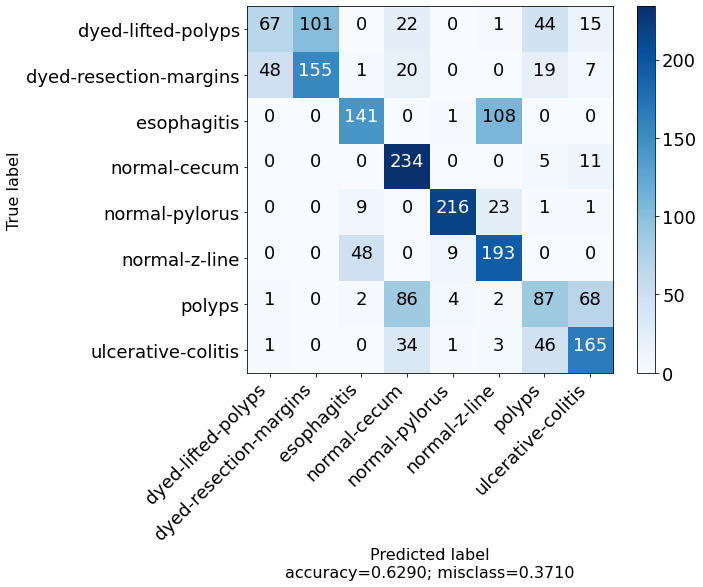

Classification report
                        precision  recall  f1-score   support
dyed-lifted-polyps       0.572650   0.268  0.365123   250.000
dyed-resection-margins   0.605469   0.620  0.612648   250.000
esophagitis              0.701493   0.564  0.625277   250.000
normal-cecum             0.590909   0.936  0.724458   250.000
normal-pylorus           0.935065   0.864  0.898129   250.000
normal-z-line            0.584848   0.772  0.665517   250.000
polyps                   0.430693   0.348  0.384956   250.000
ulcerative-colitis       0.617978   0.660  0.638298   250.000
accuracy                 0.629000   0.629  0.629000     0.629
macro avg                0.629888   0.629  0.614301  2000.000
weighted avg             0.629888   0.629  0.614301  2000.000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [86]:
"""
    Create confusion matrix and classification report
"""
rp_cm = confusion_matrix(y_test_raw_pixels, predictions_rp)
rp_cr = classification_report(y_test_raw_pixels, predictions_rp, target_names=unique_labels, output_dict=True)

rp_cr_df = pd.DataFrame(rp_cr).transpose()
rp_cr_df.to_csv('results/knn_pixel_intensity/knn_pixel_intensity_classification_report.csv', sep=';')

plot_confusion_matrix(rp_cm, unique_labels, normalize=False, save_path='results/knn_pixel_intensity/knn_pixel_intensity_confusion_matrix.png')

print("Classification report")
print(rp_cr_df)

if RunningInCOLAB:
    files.download('results/knn_pixel_intensity/knn_pixel_intensity_classification_report.csv')
    files.download('results/knn_pixel_intensity/knn_pixel_intensity_confusion_matrix.png')

### 4.2 Color histogram model

In [87]:
"""
    Use model to predict on unseen test data
"""
predictions_ch = best_model_ch.predict(x_test_color_histogram)

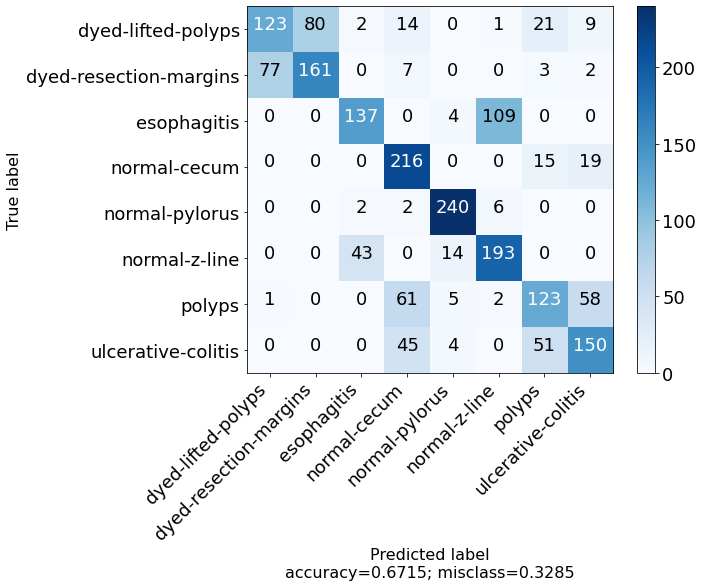

                        precision  recall  f1-score    support
dyed-lifted-polyps       0.611940  0.4920  0.545455   250.0000
dyed-resection-margins   0.668050  0.6440  0.655804   250.0000
esophagitis              0.744565  0.5480  0.631336   250.0000
normal-cecum             0.626087  0.8640  0.726050   250.0000
normal-pylorus           0.898876  0.9600  0.928433   250.0000
normal-z-line            0.620579  0.7720  0.688057   250.0000
polyps                   0.577465  0.4920  0.531317   250.0000
ulcerative-colitis       0.630252  0.6000  0.614754   250.0000
accuracy                 0.671500  0.6715  0.671500     0.6715
macro avg                0.672227  0.6715  0.665151  2000.0000
weighted avg             0.672227  0.6715  0.665151  2000.0000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
"""
    Create confusion matrix and classification report
"""
ch_cm = confusion_matrix(y_test_color_histogram, predictions_ch)
ch_cr = classification_report(y_test_color_histogram, predictions_ch, target_names=unique_labels, output_dict=True)

ch_cr_df = pd.DataFrame(ch_cr).transpose()
ch_cr_df.to_csv('results/knn_color_histogram/knn_color_histogram_classification_report.csv', sep=';')

plot_confusion_matrix(ch_cm, unique_labels, normalize=False, save_path='results/knn_color_histogram/knn_color_histogram_confusion_matrix.png')

print(ch_cr_df)

if RunningInCOLAB:
    files.download('results/knn_color_histogram/knn_color_histogram_classification_report.csv')
    files.download('results/knn_color_histogram/knn_color_histogram_confusion_matrix.png')